# Introduction

Author: Harneet Rishi

Purpose: Generate figures and analysis for Section 2 (operon effects)

# Imports

## Modules/packages

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.stats.multitest as smm
from scipy.special import comb
from scipy.stats import hypergeom
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

## Functions

### Effect size calculations

In [2]:
def calc_pooled_var(n1, var1, n2, var2):
    pooled_var = np.sqrt( ((n1 - 1)*var1 + (n2-1)*var2) / (n1 + n2 - 2) )
    return pooled_var

In [3]:
def calc_cohens_d(mean_x, mean_y, pooled_var):
    cohens_d = (mean_x - mean_y) / pooled_var
    return abs(cohens_d)

## Data

### sgRNA annotations

In [4]:
df_sgRNA_info_update_3 = pd.read_csv('SourceData/APAHR007_v4_21-df_sgRNA_info_update_3.csv')
df_sgRNA_info_update_3.drop(labels = 'seq.1', inplace = True, axis = 1)
df_sgRNA_info_update_3.set_index(keys = 'seq', inplace = True, drop = False)
df_sgRNA_info_update_3.head(10)

,seq,pos,strand,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
seq,,,,,,,,
agcggtaaaattcgtgtaat,agcggtaaaattcgtgtaat,923423,+,Promoter,,NaN,NaN,0
gcgagaaaccttattaacca,gcgagaaaccttattaacca,100609,+,Promoter,,NaN,NaN,0
ggcgtgccgatgggctacgg,ggcgtgccgatgggctacgg,3046225,-,Promoter,,NaN,NaN,0
gggctacggtggcccacacg,gggctacggtggcccacacg,3046214,-,Promoter,,NaN,NaN,0
agttgtatgatgcaactagt,agttgtatgatgcaactagt,4638701,-,Promoter,,NaN,NaN,0
cgtactgctcgggcccgaaa,cgtactgctcgggcccgaaa,2751592,+,Promoter,,NaN,NaN,0
ggaaaagttttgcgctatgt,ggaaaagttttgcgctatgt,2554,+,Promoter,,NaN,NaN,0
tagtccttccccttacggga,tagtccttccccttacggga,137014,-,Promoter,,NaN,NaN,0
tggttttatatacagtaaag,tggttttatatacagtaaag,2749746,-,Promoter,,NaN,NaN,0


In [5]:
# Essential genes based on PEC database
list_genes_ess = list(set(df_sgRNA_info_update_3[df_sgRNA_info_update_3['Class(1:essential 2:noessential 3:unknown)'] == 1]['gene_name_F2'].values))

In [6]:
# Conditionally Essential Genes in M9 (1% glycerol), aerobic, T=37C (Joyce et al J.Bac 2006)
M9_ess = 'argA , argE , argH , aroA , aroB , aroC , aroE , atpA , atpB , atpC , atpF , atpG , atpH , carA , carB , cra , crr , cysA , cysB , cysC , cysD , cysE , cysH , cysI , cysJ , cysK , cysN , cysP , cysQ , cysU , fes , folB , glnA , glpD , glpK , gltA , glyA , guaA , guaB , hisA , hisB , hisC , hisD , hisF , hisG , hisH , hisI , icd , ilvA , ilvB , ilvC , ilvD , iscS , leuA , leuB , leuC , leuD , leuL , lysA , metA , metB , metC , metF , metL , metR , nadA , nadB , nadC , pabA , pabB , panB , panC , panD , panZ , pdxA , pdxB , pdxH , pdxJ , pheA , ppc , proA , proB , proC , ptsI , purA , purC , purD , purE , purF , purH , purK , purL , purM , pyrB , pyrC , pyrD , pyrE , pyrF , serA , serB , serC , thrA , thrB , thrC , thyA , trpA , trpB , trpC , trpD , trpE , tyrA , ubiG , ubiH'.split(',')
M9_ess = [g.replace(' ', '') for g in M9_ess]

### TU/Operon mappings

In [7]:
colnames = ['(1) RegulonDB Gene ID',
           '(2) Gene name', '(3) bnumber', '(4) Gene_pos_left', '(5) Gene_pos_right',
           '(6) DNA strand where gene is coded', '(7) Product name', '(8) Evidence for gene exist',
           '(9) PMIDs list', '(10) Evidence confidence (Confirmed, Strong, Weak)']

GeneSet = pd.read_table('Annotations/RegulonDBAnnotations_052018/GeneProductSet.txt', skiprows = 38, names = colnames)
GeneSet.set_index(keys = '(1) RegulonDB Gene ID', inplace = True, drop = False)
GeneSet

,(1) RegulonDB Gene ID,(2) Gene name,(3) bnumber,(4) Gene_pos_left,(5) Gene_pos_right,(6) DNA strand where gene is coded,(7) Product name,(8) Evidence for gene exist,(9) PMIDs list,"(10) Evidence confidence (Confirmed, Strong, Weak)"
(1) RegulonDB Gene ID,,,,,,,,,,
ECK120001251,ECK120001251,thrL,b0001,190.0,255.0,forward,thr operon leader peptide,"[IDA|S|Inferred from direct assay],[IMP|W|Infe...","3112412,318654,6811557,",Strong
ECK120000987,ECK120000987,thrA,b0002,337.0,2799.0,forward,aspartate kinase / homoserine dehydrogenase,NaN,NaN,NaN
ECK120000988,ECK120000988,thrB,b0003,2801.0,3733.0,forward,homoserine kinase,NaN,NaN,NaN
ECK120000989,ECK120000989,thrC,b0004,3734.0,5020.0,forward,threonine synthase,NaN,NaN,NaN
ECK120002701,ECK120002701,yaaX,b0005,5234.0,5530.0,forward,putative protein,NaN,"24391520,",NaN
...,...,...,...,...,...,...,...,...,...,...
ECK120004447,ECK120004447,yjjY,b4402,4640402.0,4640542.0,forward,putative protein,NaN,NaN,NaN
ECK120002186,ECK120002186,yjtD,b4403,4640942.0,4641628.0,forward,predicted rRNA methyltransferase,NaN,NaN,NaN
ECK120002630,ECK120002630,alaB,NaN,NaN,NaN,NaN,glutamate-pyruvate aminotransferase,NaN,"396446,4146872,",NaN


In [8]:
df_map_ann_PromInTUSet_dropnapromotername = pd.read_csv('SourceData/APAHR007_v4_27-df_map_ann_PromInTUSet_dropnapromotername.csv')
df_map_ann_PromInTUSet_dropnapromotername.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
df_map_ann_PromInTUSet_dropnapromotername.head()

,sgRNA seq,promoter ECK#,mapping orientation,(2) Promoter Name,(3) DNA strand where promoter is loc,(4) Genome map position of TSS (+1),(5) Sigma Factor of Promoter,(6) Promoter Seq (+1 upp case),(7) Evidence for promoter exist,"(8) Evidence confidence (Confirmed, Strong, Weak)",LB_ae_avgLR_nmed,M9Ca_ae_avgLR_nmed,M9_ae_avgLR_nmed,ET165_LB_ae_t0,M9_t0_BR2_glu+gly,(2) TU name,(3) Operon name containing TU,(4) Name of the gene(s) in TU,(5) Promoter Name,(6) Evidence for TU exist,"(7) Evidence confidence (Confirmed, Strong, Weak)",#EssGene_TU_LB,#EssGene_TU_M9,sgRNA_midpos_genome,rel_pos_sgRNA_Plus1,FDR_LB,FDR_M9Ca,FDR_M9
0,acagcaatgttgctctcgcc,ECK125135055,for map,aaeXp,reverse,3389430,NaN,tcacataatatagataacagcataacagttacgctaatatattaaa...,[HTTIM|S|High-throughput transcription initiat...,Strong,-0.313167,0.331462,0.620627,82.0,38.0,['aaeXAB'],['aaeXAB'],"['aaeX,aaeA,aaeB']",['aaeXp'],['[ICWHO|W|Inferred computationally without hu...,['Weak'],0,0,12.0,-26.0,9.890545e-01,7.059563e-01,2.712005e-01
1,cgggcttgctatctcgctga,ECK120010467,for map,accAp,forward,208411,Sigma70,gcccgggaaaaatatgctcgcgggcttgctatctcgctgacggaca...,[TIM|S|Transcription initiation mapping],Strong,-2.240971,-3.774839,-2.753064,19.0,11.0,['accA'],['accA'],['accA'],['accAp'],['[LTED|S|Length of transcript experimentally ...,['Strong'],1,0,31.0,-7.0,1.711770e-06,1.585303e-05,1.073859e-03
2,ttgctatctcgctgacggac,ECK120010467,for map,accAp,forward,208411,Sigma70,gcccgggaaaaatatgctcgcgggcttgctatctcgctgacggaca...,[TIM|S|Transcription initiation mapping],Strong,-0.386808,-0.123914,0.104413,43.0,12.0,['accA'],['accA'],['accA'],['accAp'],['[LTED|S|Length of transcript experimentally ...,['Strong'],1,0,13.0,-25.0,5.706164e-01,9.573531e-01,1.000000e+00
3,cccgggaaaaatatgctcgc,ECK120010467,for map,accAp,forward,208411,Sigma70,gcccgggaaaaatatgctcgcgggcttgctatctcgctgacggaca...,[TIM|S|Transcription initiation mapping],Strong,-3.218641,-3.511805,-3.351684,9.0,9.0,['accA'],['accA'],['accA'],['accAp'],['[LTED|S|Length of transcript experimentally ...,['Strong'],1,0,2564.0,-17.0,5.105904e-15,1.094707e-04,7.781950e-05
4,gcccgggaaaaatatgctcg,ECK120010467,for map,accAp,forward,208411,Sigma70,gcccgggaaaaatatgctcgcgggcttgctatctcgctgacggaca...,[TIM|S|Transcription initiation mapping],Strong,-4.187160,-5.047858,-4.026083,66.0,28.0,['accA'],['accA'],['accA'],['accAp'],['[LTED|S|Length of transcript experimentally ...,['Strong'],1,0,55183.0,-37.0,3.297516e-26,4.209305e-13,5.625375e-10


### p-values

In [9]:
df_topd24t0_LB = pd.read_csv('SourceData/edgeR_3-topd24t0_LB_ae.csv')
df_topd24t0_LB.set_index(keys = 'seq', inplace = True, drop = False)
df_topd24t0_LB.head()

,seq,gene_name,spacer_id,logFC,logCPM,PValue,FDR
seq,,,,,,,
caatacgttgtgctagttcc,caatacgttgtgctagttcc,prs,caatacgttgtgctagttcc_prs,-11.605178,5.513031,3.057221e-96,3.132417e-94
cgcgatccaccagtaagaac,cgcgatccaccagtaagaac,fabZ,cgcgatccaccagtaagaac_fabZ,-11.402736,5.307910,3.035710e-179,1.192311e-176
agtcacctgctgccccacgt,agtcacctgctgccccacgt,aspS,agtcacctgctgccccacgt_aspS,-11.212790,5.106886,8.700724e-56,3.797014e-54
aaaagtcgagaaacgcctga,aaaagtcgagaaacgcctga,alaS,aaaagtcgagaaacgcctga_alaS,-11.164131,5.057755,1.252057e-52,5.031408e-51
accaaaaatggaaagcgttc,accaaaaatggaaagcgttc,thyA,accaaaaatggaaagcgttc_thyA,-11.140033,5.039507,2.698944e-43,8.578378e-42


### Fitness values

In [10]:
df_LRs_GEq_2e6 = pd.read_csv('SourceData/APAHR007_v4_20-df_LRs_GEq_2e6.csv')
df_LRs_GEq_2e6_nmed = pd.read_csv('SourceData/APAHR007_v4_20-df_LRs_GEq_2e6_nmed.csv')
df_LRs_GEq_2e6_nmed.set_index(keys = 'seq', inplace = True, drop = False)

cols_LB = [u'd24_tR2_LR_nmed', u'd24_tR3_LR_nmed', u'ET165_LB_ae_d24_B5T2_LR_nmed', u'ET165_LB_ae_d24_B6T2_LR_nmed',
           u'ET165_R1_1.25mL_d24_LR_nmed', u'ET165_R2_1.25mL_d24_LR_nmed', u'ET165_R3.1_1mL_d24_LR_nmed',
           u'ET165_R3.2_1mL_d24_LR_nmed', u'ET165_R4_2mL_d24_LR_nmed']
cols_M9Ca = [ u'M9_B2T1_d24_Ca_LR_nmed', u'M9_B2T2_d24_Ca_LR_nmed', u'M9_B2T3_d24_Ca_LR_nmed']
cols_M9 = [u'M9_B2T1_d24_LR_nmed', u'M9_B2T2_d24_LR_nmed', u'M9_B2T3_d24_LR_nmed']

df_LRs_GEq_2e6_nmed['LB_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_LB].mean(axis = 1)
df_LRs_GEq_2e6_nmed['M9Ca_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_M9Ca].mean(axis = 1)
df_LRs_GEq_2e6_nmed['M9_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_M9].mean(axis = 1)

cols_to_transfer = [u'strand', u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', 
                    u'Class(1:essential 2:noessential 3:unknown)']
for col in cols_to_transfer:
    df_LRs_GEq_2e6_nmed[col] = df_sgRNA_info_update_3[col]
    
sel_cols = ['seq','LB_ae_avgLR_nmed', 'M9Ca_ae_avgLR_nmed', 'M9_ae_avgLR_nmed',
            u'ET165_LB_ae_t0', u'M9_t0_BR2_glu+gly',
            u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', 
                    u'Class(1:essential 2:noessential 3:unknown)']
df_LRs_GEq_2e6_nmed_selcols = df_LRs_GEq_2e6_nmed[sel_cols]

df_LRs_GEq_2e6_nmed_selcols['LB_logFC'] = df_topd24t0_LB['logFC']
df_LRs_GEq_2e6_nmed_selcols['LB_FDR'] = df_topd24t0_LB['FDR']

In [11]:
df_OperonOrder_EssGeneNumGeq1_corrected = pd.read_csv('SourceData/APAHR007_v4_22-df_OperonOrder_EssGeneNumGeq1_corrected.csv')
df_OperonOrder_EssGeneNumGeq1_corrected.drop(labels = 'TU name.1', axis = 1, inplace = True)
df_OperonOrder_EssGeneNumGeq1_corrected.set_index(keys = 'TU name', inplace = True, drop = False)
df_OperonOrder_EssGeneNumGeq1_corrected

,TU name,TU left end pos chrom,TU right end pos chrom,DNA strand where TU is coded,# Genes in TU,Genes in TU,Essential_Gene_Pos,Essential_Gene_Num,avgLRs_LB_ae_nmed_TU,KD_efficiency_LB_ae,Rationale,Need Mod?,KD_efficiency_LB_ae(corrected)
TU name,,,,,,,,,,,,,
accA,accA,208621,209580,forward,1,accA,[1],1,[-6.6033458708107098],{},NaN,NaN,NaN
accBC,accBC,3403458,3405288,forward,2,"accB,accC","[1, 1]",2,"[-7.7050013411926352, -6.1748422462759223]",{},NaN,NaN,NaN
accD,accD,2431034,2431948,reverse,1,accD,[1],1,[-7.1740788292082289],{},NaN,NaN,NaN
adk,adk,496399,497043,forward,1,adk,[1],1,[-8.0699215427087339],{},NaN,NaN,NaN
alaS,alaS,2817403,2820033,reverse,1,alaS,[1],1,[-5.9920623043938397],{},NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
yqgEF,yqgEF,3090959,3091938,forward,2,"yqgE,yqgF","[0, 1]",1,"[-4.7214492866044182, -1.4987049743168381]",{1: 1.0},**Y (yqgE promoter is comp predicted) -> valid...,NaN,NaN
yrbG-kdsDC-lptCAB-rpoN-hpf-ptsN-yhbJ-npr,yrbG-kdsDC-lptCAB-rpoN-hpf-ptsN-yhbJ-npr,3338297,3346260,forward,11,"yrbG,kdsD,kdsC,lptC,lptA,lptB,rpoN,hpf,ptsN,yh...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]",4,"[0.081197501071603895, -2.5868939904125337, -7...",{2: 0.5},"kdsC(Egene@3) has own promoters, but KD of kds...",NaN,NaN
yrdD-tsaC-aroE-yrdB,yrdD-tsaC-aroE-yrdB,3427788,3429984,reverse,4,"yrdB,aroE,tsaC,yrdD","[0, 1, 0, 0]",1,"[-0.79216702579578713, -3.6469475459778433, -0...",{1: 0.0},"**yrdD has own promoter (RegulonDB exp evid), ...",NaN,NaN


# Analysis & Visualizations

## Figure 2c

### Mini Genome Browser Viz Functions

In [12]:
from matplotlib.path import Path
import matplotlib.patches as patches

In [13]:
def get_promoter_info(gene_name):
    groSL_regulated_promoters = df_map_ann_PromInTUSet_dropnapromotername[(df_map_ann_PromInTUSet_dropnapromotername['(2) Promoter Name'].str.contains(gene_name))]
    groSL_regulated_promoters.set_index(keys = 'sgRNA seq', inplace = True, drop = False)
    dict_MapOrientStrand = {'for map': 'T', 'rev map': 'NT'}
    groSL_regulated_promoters['id'] = ''
    for sgRNA in groSL_regulated_promoters.index:
        mapping_orientation = groSL_regulated_promoters['mapping orientation'][sgRNA]
        promoter_name = groSL_regulated_promoters['(2) Promoter Name'][sgRNA]
        groSL_regulated_promoters['id'][sgRNA] = '%s (%s)' %(promoter_name, dict_MapOrientStrand[mapping_orientation])
    
    groSL_promoters_LRs = df_LRs_GEq_2e6_nmed_selcols.loc[groSL_regulated_promoters['sgRNA seq'].values]
    groSL_promoters_LRs['id'] = ''
    groSL_promoters_LRs['id'] = groSL_regulated_promoters['id']
    groSL_promoters_LRs_t0filt = groSL_promoters_LRs[(groSL_promoters_LRs['ET165_LB_ae_t0'] >= 5)]
    #sel_cols = ['LB_ae_avgLR_nmed', 'ET165_LB_ae_t0', 'FDR_LB', 'id']
    sel_cols = ['LB_ae_avgLR_nmed', 'ET165_LB_ae_t0', 'id']
    groSL_promoters_LRs_t0filt_selcols = groSL_promoters_LRs_t0filt[sel_cols]
    for col in ['(2) Promoter Name', '(3) DNA strand where promoter is loc', '(4) Genome map position of TSS (+1)', 'mapping orientation' ,'id']:
        groSL_promoters_LRs_t0filt_selcols[col] = groSL_regulated_promoters[col]    
    
    return groSL_promoters_LRs_t0filt_selcols

In [14]:
def plot_promoter_patch(df_promoter, ax, scale):
    TSS_pos_genome = df_promoter.iloc[0]['(4) Genome map position of TSS (+1)']
    promoter_strand_genome = df_promoter.iloc[0]['(3) DNA strand where promoter is loc']
    if promoter_strand_genome == 'forward':
        p1 = [TSS_pos_genome - 60, 0]
        p2 = [TSS_pos_genome - 60, 3]
        p3 = [TSS_pos_genome, 3]
        arrow = '>'
    else:
        p1 = [TSS_pos_genome + 60, 0]
        p2 = [TSS_pos_genome + 60, -3]
        p3 = [TSS_pos_genome, -3]
        arrow = '<'
    
    verts = [p1, p2, p3]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, edgecolor  = 'gray')
    ax.add_patch(patch)
    ax.plot(verts[-1][0], verts[-1][1], arrow, lw=2, color = 'gray', markeredgecolor = 'gray', ms = scale)
    return

In [15]:
def plot_gene_patch_2(df, ax, color):
    strand = df['(6) DNA strand where gene is coded'].values
    xmin = df['(4) Gene_pos_left'].values
    xmax = df['(5) Gene_pos_right'].values
    
    if strand == 'forward':
        strand_factor = 1
        p1 = [xmin, 0]
        p2 = [xmin, 2*strand_factor]
        p3 = [xmax - 25, 2*strand_factor]
        p4 = [xmax, strand_factor]
        p5 = [xmax - 25, 0]
    else:
        strand_factor = -1
        p1 = [xmin + 25, 0]
        p2 = [xmax, 0]
        p3 = [xmax, 2*strand_factor]
        p4 = [xmin + 25, 2*strand_factor]
        p5 = [xmin, strand_factor]
            
    verts = [p1, p2, p3, p4, p5, (0,0)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor = color, lw = 1, edgecolor = 'gray')
    ax.add_patch(patch)
    
    return

### Top panel: effect w/in operon: rpoZ-spoT-trmH-recG

#### Annotation info

In [16]:
3820129-3822106, 3820423-3822400, 3822538-3824515, 3823233-3825210

(-1977, -1977, -1977, -1977)

#### Visualization

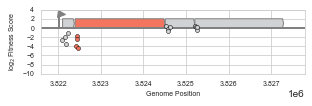

In [17]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (120/25.4, 30/25.4))
plt.rcParams["font.family"] = "Arial"
ax = fig.add_subplot(1,1,1)
ax.axhline(y = 0, color = 'gray', lw = 2)

gene1 = 'rpoZ'
gene2 = 'spoT'
gene3 = 'trmH'
gene4 = 'recG'

list_genes = [gene1, gene2, gene3, gene4]

annotation_offset = 1977
color_promoter_sgRNA = sns.color_palette('deep')[0]
color_promoter_sgRNA = 'gray'
color_gene_sgRNA = 'gray'

###Draw gene graphics
dict_genes_coords = {gene:GeneSet[GeneSet['(2) Gene name'] == gene] for gene in list_genes}

colors = ['#D1D2D4','#F37560', '#D1D2D4', '#D1D2D4']

leg_patches = []
i = 0
for gene in list_genes:
    df = dict_genes_coords[gene]
    plot_gene_patch_2(df, ax, colors[i])
    leg_patches.append(patches.Patch(color = colors[i], label = gene))
    plt.ylim([-10,4])
    i+=1
plt.legend(handles = leg_patches, loc = 'lower left')
    
plt.xlim([dict_genes_coords[gene1]['(4) Gene_pos_left'].values - 500,
         dict_genes_coords[gene4]['(5) Gene_pos_right'].values + 500])


###Plot gene sgRNAs
dict_genes_data = {gene:df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'] == gene] for gene in list_genes}

i = 0
for gene in list_genes:
    df = dict_genes_data[gene]
    for sgRNA in df.index:
        sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
        DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
        Fitness = df.loc[sgRNA]['LB_ae_avgLR_nmed']
        
        if DNAstrandsgRNA == '+':
            plt.plot([sgRNA_pos+10], [Fitness], 'o', label = 'sgRNA', color = colors[i], ms = 4, mew=0.5, mec='k')
        else:
            plt.plot([sgRNA_pos+10], [Fitness], 'o', label = 'sgRNA', color = colors[i], ms = 4, mew=0.5, mec='k')
            
    i += 1


###### Plot rpoZp, which has no sgRNAs in library
TSS_pos_genome = 3822077
promoter_strand_genome = 'forward'
if promoter_strand_genome == 'forward':
    p1 = [TSS_pos_genome - 60, 0]
    p2 = [TSS_pos_genome - 60, 3]
    p3 = [TSS_pos_genome, 3]
    arrow = '>'
else:
    p1 = [TSS_pos_genome + 60, 0]
    p2 = [TSS_pos_genome + 60, -3]
    p3 = [TSS_pos_genome, -3]
    arrow = '<'
    
verts = [p1, p2, p3]
codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='none', lw=2, edgecolor  = 'gray')
ax.add_patch(patch)
ax.plot(verts[-1][0], verts[-1][1], arrow, lw=2, color = 'gray', markeredgecolor = 'gray', ms = 7)

        

plt.xlabel('Genome Position', fontsize = 7)
plt.ylabel('log$_2$ Fitness Score', fontsize = 7)
plt.tick_params('both', labelsize = 7)
ax.get_legend().remove()
plt.ylim([-10,4])
ax.set_yticks(np.arange(-10,4+1,2))

plt.savefig('Section 2/Fig_2_c-operon-yesKD_AltColor.pdf', type = 'pdf')

#### Data Table

In [18]:
genes_to_viz = ['rpoZ', 'spoT', 'trmH', 'recG']

df_promoter_info = get_promoter_info('rpoZ').reset_index(drop=False)
df_promoter_info['category'] = 'Promoter'
df_promoter_info = df_promoter_info[['seq', 'LB_ae_avgLR_nmed', 'category', '(2) Promoter Name', '(3) DNA strand where promoter is loc']]

df_gene_info = df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'].isin(genes_to_viz)].reset_index(drop=True)
df_gene_info = df_gene_info[['seq', 'LB_ae_avgLR_nmed', 'category', 'gene_name_F2', 'bnumber_F2', 'Class(1:essential 2:noessential 3:unknown)']]
df_Fig2C_top = pd.concat([df_promoter_info, df_gene_info], axis=0)

### Bottom panel: no effect b/c internal promoter: rnpB,garK,garR,garL,garP

#### Annotation info

In [19]:
3268238-3270216, 3268647-3270625, 3269889-3271867, 3270809-3272787, 3271595-3273573

(-1978, -1978, -1978, -1978, -1978)

#### Visualization

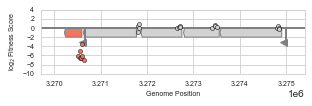

In [20]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (120/25.4, 30/25.4))
plt.rcParams["font.family"] = "Arial"
ax = fig.add_subplot(1,1,1)
ax.axhline(y = 0, color = 'gray', lw = 2)

gene1 = 'rnpB'
gene2 = 'garK'
gene3 = 'garR'
gene4 = 'garL'
gene5 = 'garP'

list_genes = [gene1, gene2, gene3, gene4, gene5]

annotation_offset = 1978
color_promoter_sgRNA = sns.color_palette('deep')[0]
color_promoter_sgRNA = 'gray'
color_gene_sgRNA = 'gray'

###Draw gene graphics
dict_genes_coords = {gene:GeneSet[GeneSet['(2) Gene name'] == gene] for gene in list_genes}

colors = ['#F37560', '#D1D2D4', '#D1D2D4', '#D1D2D4',
          '#D1D2D4', '#D1D2D4']

leg_patches = []
i = 0
for gene in list_genes:
    df = dict_genes_coords[gene]
    plot_gene_patch_2(df, ax, colors[i])
    leg_patches.append(patches.Patch(color = colors[i], label = gene))
    plt.ylim([-10,4])
    i+=1
plt.legend(handles = leg_patches, loc = 'lower left')
    
plt.xlim([dict_genes_coords[gene1]['(4) Gene_pos_left'].values - 500,
         dict_genes_coords[gene5]['(5) Gene_pos_right'].values + 500])


###Plot gene sgRNAs
dict_genes_data = {gene:df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'] == gene] for gene in list_genes}

i = 0
for gene in list_genes:
    df = dict_genes_data[gene]
    for sgRNA in df.index:
        sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
        DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
        Fitness = df.loc[sgRNA]['LB_ae_avgLR_nmed']
        plt.plot([sgRNA_pos+10], [Fitness], 'o', label = 'sgRNA', color = colors[i], ms = 4, mew=0.5, mec='k')
            
    i += 1


###Plot promoter graphics
df_promoter = get_promoter_info(gene1)

for promoter in df_promoter['(2) Promoter Name'].unique():
    df = df_promoter[df_promoter['(2) Promoter Name'] == promoter]
    plot_promoter_patch(df, ax, 7)

###Plot promoter sgRNAs
for sgRNA in df_promoter.index:
    sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
    DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
    Fitness = df_promoter.loc[sgRNA]['LB_ae_avgLR_nmed']
    plt.plot([sgRNA_pos+10], [Fitness], 'o', label = 'sgRNA', color =  '#F37560', ms = 4, mew=0.5, mec='k')


        
###### Plot garPp, which has no sgRNAs in library
TSS_pos_genome = 3274934
promoter_strand_genome = 'reverse'
if promoter_strand_genome == 'forward':
    p1 = [TSS_pos_genome - 60, 0]
    p2 = [TSS_pos_genome - 60, 3]
    p3 = [TSS_pos_genome, 3]
    arrow = '>'
else:
    p1 = [TSS_pos_genome + 60, 0]
    p2 = [TSS_pos_genome + 60, -3]
    p3 = [TSS_pos_genome, -3]
    arrow = '<'
    
verts = [p1, p2, p3]
codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='none', lw=2, edgecolor  = 'gray')
ax.add_patch(patch)
ax.plot(verts[-1][0], verts[-1][1], arrow, lw=2, color = 'gray', markeredgecolor = 'gray', ms = 7)


plt.xlabel('Genome Position', fontsize = 7)
plt.ylabel('log$_2$ Fitness Score', fontsize = 7)
plt.tick_params('both', labelsize = 7)
ax.get_legend().remove()
plt.ylim([-10,4])
ax.set_yticks(np.arange(-10,4+1,2))

plt.savefig('Section 2/Fig_2_c-operon-noKD_AltColor.pdf', type = 'pdf')

#### Data Table

In [21]:
genes_to_viz = ['rnpB', 'garK', 'garR', 'garL', 'garP']

df_promoter_info = get_promoter_info('rnpB').reset_index(drop=False)
df_promoter_info['category'] = 'Promoter'
df_promoter_info = df_promoter_info[['seq', 'LB_ae_avgLR_nmed', 'category', '(2) Promoter Name', '(3) DNA strand where promoter is loc']]

df_gene_info = df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'].isin(genes_to_viz)].reset_index(drop=True)
df_gene_info = df_gene_info[['seq', 'LB_ae_avgLR_nmed', 'category', 'gene_name_F2', 'bnumber_F2', 'Class(1:essential 2:noessential 3:unknown)']]
df_Fig2C_bot = pd.concat([df_promoter_info, df_gene_info], axis=0)

### Data Export

In [22]:
df_Fig2c = pd.concat([df_Fig2C_top, df_Fig2C_bot], axis=0).reset_index(drop=True)
df_Fig2c.to_excel('Section 2/Table_Fig-2c.xlsx')
df_Fig2c

,seq,LB_ae_avgLR_nmed,category,(2) Promoter Name,(3) DNA strand where promoter is loc,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
0,ccatacttaaaaagctccac,-2.598776,All_Genes,NaN,NaN,rpoZ,b3649,2.0
1,gacgcgcggcgaccagtacc,-2.020499,All_Genes,NaN,NaN,rpoZ,b3649,2.0
2,catctgacgagcgcgacgcg,-3.492735,All_Genes,NaN,NaN,rpoZ,b3649,2.0
3,tcgttttcttccggtaccag,-1.166576,All_Genes,NaN,NaN,rpoZ,b3649,2.0
4,aggtttgaatcagttgattc,-4.031250,All_Genes,NaN,NaN,spoT,b3650,1.0
5,gatttggtcttccggcaggt,-1.710958,All_Genes,NaN,NaN,spoT,b3650,1.0
6,gcttgatttggtcttccggc,-2.424201,All_Genes,NaN,NaN,spoT,b3650,1.0
7,agacgcttgatttggtcttc,-4.375780,All_Genes,NaN,NaN,spoT,b3650,1.0
8,cagatgcgtgcataacgtgt,0.370419,All_Genes,NaN,NaN,trmH,b3651,2.0
9,ggtcagatcaggctgccgcc,-0.330908,All_Genes,NaN,NaN,trmH,b3651,2.0


## Figure 2d

### Process

In [23]:
df_OperonOrder_EssGeneNumGeq1_corrected['KD_efficiency_LB_ae_vals'] = df_OperonOrder_EssGeneNumGeq1_corrected['KD_efficiency_LB_ae']

ind_to_correct = df_OperonOrder_EssGeneNumGeq1_corrected[df_OperonOrder_EssGeneNumGeq1_corrected['Need Mod?'] == 'Y'].index

for ind in ind_to_correct:
    df_OperonOrder_EssGeneNumGeq1_corrected['KD_efficiency_LB_ae_vals'].loc[ind] = df_OperonOrder_EssGeneNumGeq1_corrected['KD_efficiency_LB_ae(corrected)'].loc[ind]

In [24]:
list_KDeffOP_LBae_corrected = []

for dict_KDeffOP in df_OperonOrder_EssGeneNumGeq1_corrected['KD_efficiency_LB_ae_vals'].values:
    for val in eval(dict_KDeffOP).values():
        list_KDeffOP_LBae_corrected.append(val)

In [25]:
[(i,list_KDeffOP_LBae_corrected.count(i)) for i in set(list_KDeffOP_LBae_corrected)]

[(0.0, 7), (1.0, 38), (0.75, 1), (0.5, 1)]

### Visualize

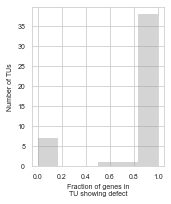

In [26]:
sns.set_style('whitegrid')
#fig = plt.figure(figsize = (40/25.4, 60/25.4))
fig = plt.figure(figsize = (60/25.4, 74.5/25.4))
plt.rcParams["font.family"] = "Arial"
ax111 = fig.add_subplot(1,1,1)


sns.distplot(list_KDeffOP_LBae_corrected, kde = False, ax = ax111, color= sns.color_palette('Greys',3)[1],
            hist_kws = {'linewidth': 0})

plt.ylabel('Number of TUs', fontsize = 7)
plt.xlabel('Fraction of genes in\nTU showing defect', fontsize = 7)
plt.tick_params('both', labelsize = 7)

plt.savefig('Section 2/Fig_2_d-FractionDefect-barplot.pdf', type = 'pdf')

### Inspect elements

In [27]:
df_OperonOrder_EssGeneNumGeq1_corrected[df_OperonOrder_EssGeneNumGeq1_corrected['KD_efficiency_LB_ae_vals'].str.contains('0.0')]

,TU name,TU left end pos chrom,TU right end pos chrom,DNA strand where TU is coded,# Genes in TU,Genes in TU,Essential_Gene_Pos,Essential_Gene_Num,avgLRs_LB_ae_nmed_TU,KD_efficiency_LB_ae,Rationale,Need Mod?,KD_efficiency_LB_ae(corrected),KD_efficiency_LB_ae_vals
TU name,,,,,,,,,,,,,,
btuB-murI,btuB-murI,4161662,4164308,forward,2,"btuB,murI","[0, 1]",1,"[0.077437954860287844, -4.4246780334160754]",{1: 0.0},"1/4 guides shows a true effect, so median scor...",NaN,NaN,{1: 0.0}
folP-glmM,folP-glmM,3320755,3322933,reverse,2,"glmM,folP","[0, 1]",1,"[-0.23370891399243801, -4.4911053110157519]",{1: 0.0},interesting case - glmM(E) doesn't have its ow...,NaN,NaN,{1: 0.0}
pepQ-yigZ-trkH-hemG,pepQ-yigZ-trkH-hemG,4029184,4033176,forward,4,"pepQ,yigZ,trkH,hemG","[0, 0, 0, 1]",1,"[0.14046722529203587, -0.042284520362846745, -...",{3: 0.0},hemG(E) doesn't show effect -> bad guide; foll...,NaN,NaN,{3: 0.0}
smtA-mukFEB,smtA-mukFEB,972760,980009,forward,4,"smtA,mukF,mukE,mukB","[0, 1, 1, 1]",3,"[-0.69364363697100595, -2.529759034761065, -4....",{1: 0.0},interesting case - no mukF(E) promoter annotat...,NaN,NaN,{1: 0.0}
ygiM-cca,ygiM-cca,3199229,3201151,forward,2,"ygiM,cca","[0, 1]",1,"[0.37053656222876741, -0.30651876982210363]",{1: 0.0},cca shows no effect (only 1 guide shows effect),NaN,NaN,{1: 0.0}
yjeF-tsaE-amiB-mutL-miaA-hfq-hflXKC,yjeF-tsaE-amiB-mutL-miaA-hfq-hflXKC,4392089,4402327,forward,9,"yjeF,tsaE,amiB,mutL,miaA,hfq,hflX,hflK,hflC","[0, 1, 0, 0, 0, 0, 0, 0, 0]",1,"[0.18328337612594936, -3.8891182656188725, 0.1...",{1: 0.0},**tsaE has own promoter (comp predicted) on ec...,NaN,NaN,{1: 0.0}
yrdD-tsaC-aroE-yrdB,yrdD-tsaC-aroE-yrdB,3427788,3429984,reverse,4,"yrdB,aroE,tsaC,yrdD","[0, 1, 0, 0]",1,"[-0.79216702579578713, -3.6469475459778433, -0...",{1: 0.0},"**yrdD has own promoter (RegulonDB exp evid), ...",NaN,NaN,{1: 0.0}


In [28]:
df_OperonOrder_EssGeneNumGeq1_corrected[df_OperonOrder_EssGeneNumGeq1_corrected['KD_efficiency_LB_ae_vals'].str.contains('0.75')]

,TU name,TU left end pos chrom,TU right end pos chrom,DNA strand where TU is coded,# Genes in TU,Genes in TU,Essential_Gene_Pos,Essential_Gene_Num,avgLRs_LB_ae_nmed_TU,KD_efficiency_LB_ae,Rationale,Need Mod?,KD_efficiency_LB_ae(corrected),KD_efficiency_LB_ae_vals
TU name,,,,,,,,,,,,,,
yceD-rpmF-plsX-fabHDG-acpP-fabF,yceD-rpmF-plsX-fabHDG-acpP-fabF,1146017,1152403,forward,8,"yceD,rpmF,plsX,fabH,fabD,fabG,acpP,fabF","[0, 0, 0, 0, 1, 1, 1, 0]",3,"[-3.6118087268501289, -3.5733171624452362, 0.0...",{4: 0.75},interesting case - multiple promoters for Egen...,NaN,NaN,{4: 0.75}


In [29]:
df_OperonOrder_EssGeneNumGeq1_corrected[df_OperonOrder_EssGeneNumGeq1_corrected['KD_efficiency_LB_ae_vals'].str.contains('0.5')]

,TU name,TU left end pos chrom,TU right end pos chrom,DNA strand where TU is coded,# Genes in TU,Genes in TU,Essential_Gene_Pos,Essential_Gene_Num,avgLRs_LB_ae_nmed_TU,KD_efficiency_LB_ae,Rationale,Need Mod?,KD_efficiency_LB_ae(corrected),KD_efficiency_LB_ae_vals
TU name,,,,,,,,,,,,,,
yrbG-kdsDC-lptCAB-rpoN-hpf-ptsN-yhbJ-npr,yrbG-kdsDC-lptCAB-rpoN-hpf-ptsN-yhbJ-npr,3338297,3346260,forward,11,"yrbG,kdsD,kdsC,lptC,lptA,lptB,rpoN,hpf,ptsN,yh...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]",4,"[0.081197501071603895, -2.5868939904125337, -7...",{2: 0.5},"kdsC(Egene@3) has own promoters, but KD of kds...",NaN,NaN,{2: 0.5}


### Data Export

In [30]:
df_OperonOrder_EssGeneNumGeq1_corrected.columns

Index(['TU name', 'TU left end pos chrom', 'TU right end pos chrom',
       'DNA strand where TU is coded', '# Genes in TU', 'Genes in TU',
       'Essential_Gene_Pos', 'Essential_Gene_Num', 'avgLRs_LB_ae_nmed_TU',
       'KD_efficiency_LB_ae', 'Rationale', 'Need Mod?',
       'KD_efficiency_LB_ae(corrected)', 'KD_efficiency_LB_ae_vals'],
      dtype='object')

In [31]:
df_Fig2d = df_OperonOrder_EssGeneNumGeq1_corrected.copy()
cols_to_export = ['TU name', 'TU left end pos chrom', 'TU right end pos chrom',
       'DNA strand where TU is coded', '# Genes in TU', 'Genes in TU',
       'Essential_Gene_Pos', 'Essential_Gene_Num', 'avgLRs_LB_ae_nmed_TU', 'KD_efficiency_LB_ae_vals']
df_Fig2d = df_Fig2d[cols_to_export]
df_Fig2d.to_excel('Section 2/Table_Fig-2d.xlsx')
df_Fig2d

,TU name,TU left end pos chrom,TU right end pos chrom,DNA strand where TU is coded,# Genes in TU,Genes in TU,Essential_Gene_Pos,Essential_Gene_Num,avgLRs_LB_ae_nmed_TU,KD_efficiency_LB_ae_vals
TU name,,,,,,,,,,
accA,accA,208621,209580,forward,1,accA,[1],1,[-6.6033458708107098],{}
accBC,accBC,3403458,3405288,forward,2,"accB,accC","[1, 1]",2,"[-7.7050013411926352, -6.1748422462759223]",{}
accD,accD,2431034,2431948,reverse,1,accD,[1],1,[-7.1740788292082289],{}
adk,adk,496399,497043,forward,1,adk,[1],1,[-8.0699215427087339],{}
alaS,alaS,2817403,2820033,reverse,1,alaS,[1],1,[-5.9920623043938397],{}
...,...,...,...,...,...,...,...,...,...,...
yqgEF,yqgEF,3090959,3091938,forward,2,"yqgE,yqgF","[0, 1]",1,"[-4.7214492866044182, -1.4987049743168381]",{1: 1.0}
yrbG-kdsDC-lptCAB-rpoN-hpf-ptsN-yhbJ-npr,yrbG-kdsDC-lptCAB-rpoN-hpf-ptsN-yhbJ-npr,3338297,3346260,forward,11,"yrbG,kdsD,kdsC,lptC,lptA,lptB,rpoN,hpf,ptsN,yh...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]",4,"[0.081197501071603895, -2.5868939904125337, -7...",{2: 0.5}
yrdD-tsaC-aroE-yrdB,yrdD-tsaC-aroE-yrdB,3427788,3429984,reverse,4,"yrdB,aroE,tsaC,yrdD","[0, 1, 0, 0]",1,"[-0.79216702579578713, -3.6469475459778433, -0...",{1: 0.0}
